In [1]:
import Power_Laws_Generator as plg
import seaborn as sns
import numpy as np
import pandas as pd
import latexify
from sympy.functions.special.gamma_functions import gamma
import time
import matplotlib.pyplot as plt

%matplotlib inline

## Formula display for PDFs

In [4]:
identifiers = {
    'dslope_power_pdf':'p',
    'power_pdf':'p',
    'damped_power_pdf':'p',
}

@latexify.function(reduce_assignments=True, use_math_symbols=True, identifiers=identifiers)
def power_pdf(x, alpha=1.5, xmin=1):
    fx = ((alpha - 1) / xmin)*(x/xmin)**(-alpha)
    return fx

power_pdf

In [5]:
@latexify.function(reduce_assignments=True, use_math_symbols=True, identifiers=identifiers)
def damped_power_pdf(x, xmin=1, alpha=1.5, xc=100):
    C1 = (xc ** (alpha - 1)) / gamma(1-alpha, xmin/xc)
    fx = C1 * np.exp(-x/xc) * x**(-alpha)

    return fx

damped_power_pdf

In [3]:
@latexify.function(reduce_assignments=True, use_math_symbols=True, identifiers=identifiers)
def dslope_power_pdf(x, alpha=4, beta=1.5, xmin=1, xc=100, rho=0.5):
    pob1_part = rho * ((alpha - 1) / xmin) * (x/xmin)**(-alpha)
    pob2_part = (1 - rho) * ((xc ** (beta - 1)) / gamma(1-beta, xmin/xc)) * ((x/xmin)**(-beta)) * np.exp(-x/xc)
    px = pob1_part + pob2_part
    return px

dslope_power_pdf

## Synthetic Data Analysis

In [2]:
sns.set_style('dark')
n_samples = 10000
alpha1 = 4
alpha2 = 2
x_c = 100
x_min=1
top_level = 1
beta = 0.5
n = 1000
n_bins = 100
bootstrap = 100

### Pure Power Law Samplework

In [4]:
# Data Generation
print('Generating Samples...')
x = plg.analytic_power(n_samples, alpha=alpha2, x_min=x_min)
print('Samples Done!')

Generating Samples...
Samples Done!


In [7]:
alpha_pred = np.array([])

cp1 = time.perf_counter()
for _ in range(bootstrap):
    xb = plg.bootstrap_sample(x)
    alpha_pred = np.append(alpha_pred, plg.power_law_max_likelihood(xb))
cp2 = time.perf_counter()
print(f'Time ellapsed per boostrapped sample: {round(1000*(cp2-cp1)/bootstrap, 3)}ms')

# Alpha
alpha_std_bootstrap = plg.bootstrap_std(alpha_pred, bootstrap)
alpha_pred_bootstrap = np.sum(alpha_pred) / bootstrap
x_estimated = np.linspace(min(x), max(x), len(x))
px_bootstrap = plg.power_pdf(x_estimated, alpha=alpha_pred_bootstrap, x_min=x_min)

Time ellapsed per boostrapped sample: 0.255ms


In [8]:
alpha_pred = plg.power_law_max_likelihood(x)
hess = plg.power_hessian(x, alpha_pred)
print(hess)
alpha_std = np.sqrt(1/hess)
px = plg.power_pdf(x_estimated, alpha=alpha_pred, x_min=x_min)

9725.882677131089


In [9]:
errors_non_bootstrap = np.array([plg.power_pdf(x_estimated, alpha=alpha_pred + (-1)**(i//1) * alpha_std, x_min=x_min) for i in range(2)])
errors_non_bootstrap = np.array([np.max(errors_non_bootstrap, axis=0), np.min(errors_non_bootstrap, axis=0)])

errors_bootstrap = np.array([plg.power_pdf(x_estimated, alpha=alpha_pred_bootstrap + (-1)**(i//1) * alpha_std_bootstrap, x_min=x_min) for i in range(2)])
errors_bootstrap = np.array([np.max(errors_bootstrap, axis=0), np.min(errors_bootstrap, axis=0)])

errors = np.array([errors_non_bootstrap, errors_bootstrap])

Akaike Information Criteria: 39448.0339	Bayesian Information Criteria: 39455.2439
Non-Bootstrapped Samples:
	Slope Predicted: 2.0139942372287862 +- 0.010139942372287863

Bootstrapped Samples:
	Slope Predicted: 2.013730883979602 +- 0.010968625191178989


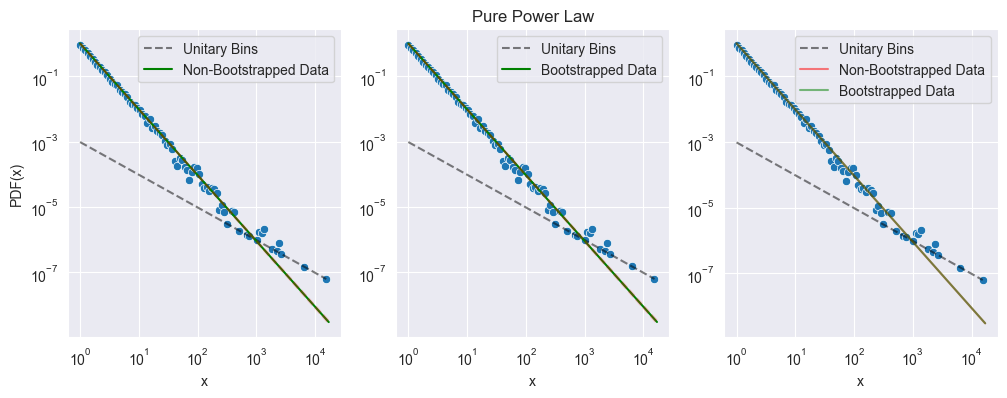

In [11]:
akaike = plg.akaike_information(x, plg.power_law_likelihood, [alpha_pred], x_min=x_min)
bayes = plg.bayesian_information(x, plg.power_law_likelihood, [alpha_pred], x_min=x_min)

print(f'Akaike Information Criteria: {round(akaike, 4)}\tBayesian Information Criteria: {round(bayes, 4)}')
print(f'Non-Bootstrapped Samples:\n\tSlope Predicted: {alpha_pred} +- {alpha_std}')
print(f'\nBootstrapped Samples:\n\tSlope Predicted: {alpha_pred_bootstrap} +- {alpha_std_bootstrap}')

plg.plot_data(x, n_bins, x_estimated, px_bootstrap, px, errors, title='Pure Power Law')

### Power Law with Cutoff Samplework

In [12]:
# Data Generation
print('Generating Samples...')
x = plg.accept_reject_damped(n_samples, alpha=alpha2, x_c=x_c, x_min=x_min)
print('Samples Done!')

Generating Samples...
Generated 10000 in 4 iterations with 2277.9% efficiency
Samples Done!


In [13]:
alpha0, x_c0 = alpha2 + np.random.uniform(-1, 1, 1), x_c + np.random.uniform(-10, 10, 1)

alpha_pred = np.array([])
x_c_pred = np.array([])

cp1 = time.perf_counter()
for _ in range(bootstrap):
    xb = plg.bootstrap_sample(x)
    result = plg.minimize_by_scipy(xb, plg.cutoff_law_likelihood, (alpha0, x_c0))
    alpha_pred = np.append(alpha_pred, result.x[0])
    x_c_pred = np.append(x_c_pred, result.x[1])
cp2 = time.perf_counter()
print(f'Time ellapsed per boostrapped sample: {round(1000*(cp2-cp1)/bootstrap, 3)}ms')
# Alpha
alpha_std_bootstrap = plg.bootstrap_std(alpha_pred, bootstrap)
alpha_pred_bootstrap = np.sum(alpha_pred)/bootstrap
# X_c
x_c_std_bootstrap = plg.bootstrap_std(x_c_pred, bootstrap)
x_c_pred_bootstrap = np.sum(x_c_pred)/bootstrap


x_estimated = np.linspace(min(x), max(x), len(x))
px_bootstrap = plg.damped_power_pdf(x_estimated, alpha=alpha_pred_bootstrap, x_c=x_c_pred_bootstrap, x_min=x_min)

Time ellapsed per boostrapped sample: 81.145ms


In [14]:
# Maximum Likelihood Estimation
result = plg.minimize_by_scipy(x, plg.cutoff_law_likelihood, (alpha0, x_c0))
alpha_pred, x_c_pred = result.x[0], result.x[1]
hess = plg.damped_power_hessian(x, alpha_pred, x_c_pred)
print(hess)
alpha_std, x_c_std = np.diagonal(np.sqrt(np.linalg.inv(hess)))
px = plg.damped_power_pdf(x_estimated, alpha=alpha_pred, x_c=x_c_pred, x_min=x_min)

[[-2.54443590e+05  1.16997821e+03]
 [ 9.72465688e+02 -1.29784458e-01]]


In [15]:
errors_non_bootstrap = []
errors_bootstrap = []
for i in range(4):
    alpha2test = max(1, alpha_pred + (-1)**(i//1)*alpha_std)
    xc2test = max(0, x_c_pred + (-1)**(i//2)*x_c_std)
    errors_non_bootstrap.append(plg.damped_power_pdf(x_estimated, alpha=alpha2test, x_c=xc2test, x_min=x_min))

    alpha2test_b = max(1, alpha_pred_bootstrap + (-1)**(i//1)*alpha_std_bootstrap)
    xc2test_b = max(0, x_c_pred_bootstrap + (-1)**(i//2)*x_c_std_bootstrap)
    errors_bootstrap.append(plg.damped_power_pdf(x_estimated, alpha=alpha2test_b, x_c=xc2test_b, x_min=x_min))

errors_non_bootstrap = np.array([np.max(np.array(errors_non_bootstrap), axis=0), np.min(np.array(errors_non_bootstrap), axis=0)])
errors_bootstrap = np.array([np.max(np.array(errors_bootstrap), axis=0), np.min(np.array(errors_bootstrap), axis=0)])

errors = np.array([errors_non_bootstrap, errors_bootstrap])

Akaike Information Criteria: 35511.1893	Bayesian Information Criteria: 35525.6088
Non-Bootstrapped Samples:
	Slope Predicted: 2.0156017969778004 +- 0.0003427529005245944
	Damping Factor Predicted: 95.83709650916413 +- 0.47991635656214504

Bootstrapped Samples:
	Slope Predicted: 2.0147427439793093 +- 0.01521402058604306
	Damping Factor Predicted: 96.1114636199977 +- 13.281108710982867


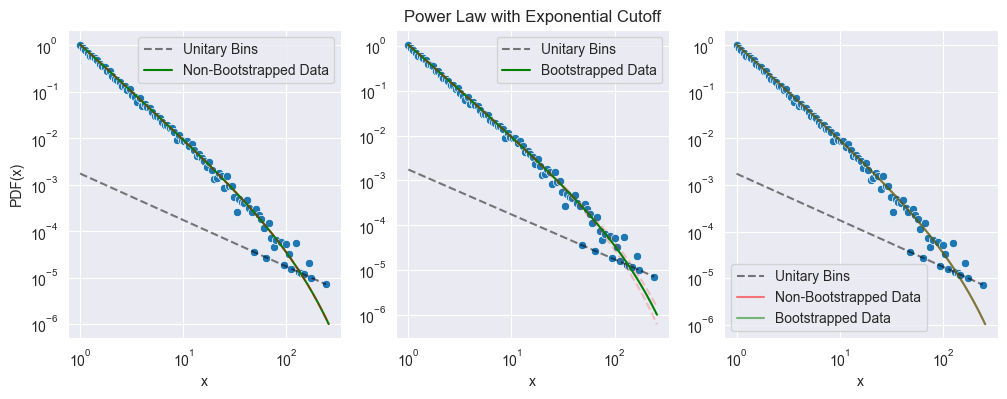

In [16]:
akaike = plg.akaike_information(x, plg.cutoff_law_likelihood, (alpha_pred, x_c_pred), x_min=x_min)
bayes = plg.bayesian_information(x, plg.cutoff_law_likelihood, (alpha_pred, x_c_pred), x_min=x_min)

print(f'Akaike Information Criteria: {round(akaike, 4)}\tBayesian Information Criteria: {round(bayes, 4)}')
print(f'Non-Bootstrapped Samples:\n\tSlope Predicted: {alpha_pred} +- {alpha_std}\n\tDamping Factor Predicted: {x_c_pred} +- {x_c_std}')
print(f'\nBootstrapped Samples:\n\tSlope Predicted: {alpha_pred_bootstrap} +- {alpha_std_bootstrap}\n\tDamping Factor Predicted: {x_c_pred_bootstrap} +- {x_c_std_bootstrap}')

plg.plot_data(x, n_bins, x_estimated, px_bootstrap, px, errors, title='Power Law with Exponential Cutoff')

### Double Power Law with Cutoff Samplework

In [3]:
# Data Generation
print('Generating Samples...')
x = plg.double_potential_generation(n_samples, alpha1=alpha1, alpha2=alpha2, x_c=x_c, beta=beta, x_min=x_min)
print('Samples Done!')

Generating Samples...
Generated 4955 in 3 iterations with 2477.5% efficiency
Samples Done!


In [4]:
alpha1_0, alpha2_0, x_c0 = alpha1 + np.random.uniform(-1, 1, 1), alpha2 + np.random.uniform(-1, 1, 1), x_c + np.random.uniform(-10, 10, 1)

alpha1_pred = np.array([])
alpha2_pred = np.array([])
x_c_pred = np.array([])

cp1 = time.perf_counter()
for _ in range(bootstrap):
    xb = plg.bootstrap_sample(x)
    result = plg.minimize_by_scipy(xb, plg.dslope_law_likelihood, (alpha1_0, alpha2_0, x_c0))
    alpha1_pred = np.append(alpha1_pred, result.x[0])
    alpha2_pred = np.append(alpha2_pred, result.x[1])
    x_c_pred = np.append(x_c_pred, result.x[2])
cp2 = time.perf_counter()
print(f'Time ellapsed per boostrapped sample: {1000 * round((cp2-cp1)/bootstrap, 3)}ms')

# Alpha1
alpha1_std_bootstrap = plg.bootstrap_std(alpha1_pred, bootstrap)
alpha1_pred_bootstrap = np.sum(alpha1_pred)/bootstrap
# Alpha2
alpha2_std_bootstrap = plg.bootstrap_std(alpha2_pred, bootstrap)
alpha2_pred_bootstrap = np.sum(alpha2_pred)/bootstrap
# X_c
x_c_std_bootstrap = plg.bootstrap_std(x_c_pred, bootstrap)
x_c_pred_bootstrap = np.sum(x_c_pred)/bootstrap

x_estimated = np.linspace(min(x), max(x), len(x))
px_bootstrap, tau_b = plg.dslope_power_pdf(x_estimated, alpha1=alpha1_pred_bootstrap, alpha2=alpha2_pred_bootstrap, x_c=x_c_pred_bootstrap, beta=beta, x_min=x_min)

Time ellapsed per boostrapped sample: 349.0ms


In [5]:
# Maximum Likelihood Estimation
result = plg.minimize_by_scipy(x, plg.dslope_law_likelihood, (alpha1_0, alpha2_0, x_c0))
alpha1_pred, alpha2_pred, x_c_pred = result.x[0], result.x[1], result.x[2]
hess = plg.dslope_power_hessian(x, alpha1_pred, alpha2_pred, x_c_pred)
print(hess)
alpha1_std, alpha2_std, x_c_std = np.diagonal(np.sqrt(abs(np.linalg.inv(hess))))
px, tau = plg.dslope_power_pdf(x_estimated, alpha1=alpha1_pred, alpha2=alpha2_pred, x_c=x_c_pred, beta=beta, x_min=x_min)

[[ 5.55715482e+02  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -1.43602021e+05  5.15894410e+02]
 [ 0.00000000e+00  4.34023153e+02 -3.92032800e-02]]


In [6]:
errors_non_bootstrap = []
errors_bootstrap = []
for i in range(8):
    alpha12test = max(1.000001, alpha1_pred + (-1)**(i//1)*alpha1_std)
    alpha22test = min(alpha12test, max(1.000001, alpha2_pred + (-1)**(i//2)*alpha2_std))
    xc2test = max(0, x_c_pred + (-1)**(i//4)*x_c_std)
    errors_non_bootstrap.append(plg.dslope_power_pdf(x_estimated, alpha1=alpha12test, alpha2=alpha22test, x_c=xc2test, beta=beta, x_min=x_min)[0])

    alpha12test_b = max(1.000001, alpha1_pred_bootstrap + (-1)**(i//1)*alpha1_std_bootstrap)
    alpha22test_b = min(alpha12test_b, max(1.000001, alpha2_pred_bootstrap + (-1)**(i//2)*alpha2_std_bootstrap))
    xc2test_b = max(0, x_c_pred_bootstrap + (-1)**(i//4)*x_c_std_bootstrap)
    # print(alpha12test_b, alpha22test_b, xc2test_b)
    errors_bootstrap.append(plg.dslope_power_pdf(x_estimated, alpha1=alpha12test_b, alpha2=alpha22test_b, x_c=xc2test_b, beta=beta, x_min=x_min)[0])

errors_non_bootstrap = np.array([np.max(np.array(errors_non_bootstrap), axis=0), np.min(np.array(errors_non_bootstrap), axis=0)])
errors_bootstrap = np.array([np.max(np.array(errors_bootstrap), axis=0), np.min(np.array(errors_bootstrap), axis=0)])

errors = np.array([errors_non_bootstrap, errors_bootstrap])

Akaike Information Criteria: 22099.7769	Bayesian Information Criteria: 22121.4055
Non-Bootstrapped Samples:
	Slope 1 Predicted: 4.0008313509256475 +- 0.04242030160450591
	Slope 2 Predicted: 2.0354635768512708 +- 0.00042379300467773866
	Damping Factor Predicted: 115.25056736317075 +- 0.8110971171267706
	Crossing Point Predicted: 56.42145455791128

Bootstrapped Samples:
	Slope 1 Predicted: 3.9962733066161706 +- 0.08239548825853286
	Slope 2 Predicted: 2.034452327207833 +- 0.03314329824132285
	Damping Factor Predicted: 120.67773290246306 +- 35.16243096011758
	Crossing Point Predicted: 57.325524278956806


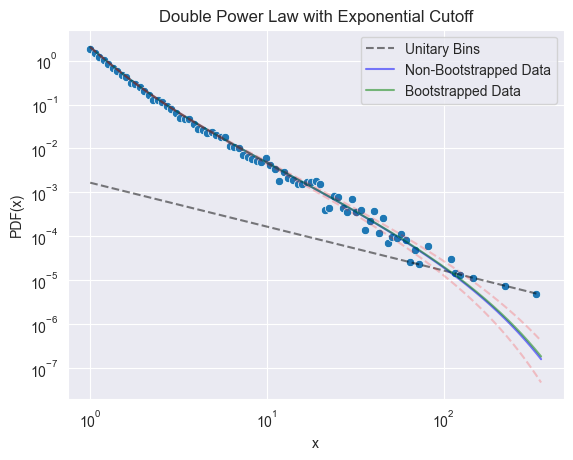

In [7]:
akaike = plg.akaike_information(x, plg.dslope_law_likelihood, (alpha1_pred, alpha2_pred, x_c_pred), x_min=x_min)
bayes = plg.bayesian_information(x, plg.dslope_law_likelihood, (alpha1_pred, alpha2_pred, x_c_pred), x_min=x_min)
print(f'Akaike Information Criteria: {round(akaike, 4)}\tBayesian Information Criteria: {round(bayes, 4)}')

print(f'Non-Bootstrapped Samples:\n\tSlope 1 Predicted: {alpha1_pred} +- {alpha1_std}\n\tSlope 2 Predicted: {alpha2_pred} +- {alpha2_std}\n\tDamping Factor Predicted: {x_c_pred} +- {x_c_std}\n\tCrossing Point Predicted: {tau}')
print(f'\nBootstrapped Samples:\n\tSlope 1 Predicted: {alpha1_pred_bootstrap} +- {alpha1_std_bootstrap}\n\tSlope 2 Predicted: {alpha2_pred_bootstrap} +- {alpha2_std_bootstrap}\n\tDamping Factor Predicted: {x_c_pred_bootstrap} +- {x_c_std_bootstrap}\n\tCrossing Point Predicted: {tau_b}')

plg.plot_data(x, n_bins, x_estimated, px_bootstrap, px, errors, title='Double Power Law with Exponential Cutoff')

### Double Power Law with Cutoff and Unknown Population Distribution Samplework

In [8]:
# Data Generation
print('Generating Samples...')
x = plg.double_potential_generation(n_samples, alpha1=alpha1, alpha2=alpha2, x_c=x_c, beta=beta, x_min=x_min)
print('Samples Done!')

Generating Samples...
Generated 4975 in 3 iterations with 2282.11% efficiency
Samples Done!


In [9]:
alpha1_0, alpha2_0, x_c0, beta0 = alpha1 + np.random.uniform(-1, 1, 1), alpha2 + np.random.uniform(-1, 1, 1), x_c + np.random.uniform(-10, 10, 1), beta + np.random.uniform(-0.3, 0.3, 1)

alpha1_pred = np.array([])
alpha2_pred = np.array([])
x_c_pred = np.array([])
beta_pred = np.array([])

cp1 = time.perf_counter()
for _ in range(bootstrap):
    xb = plg.bootstrap_sample(x)
    result = plg.minimize_by_scipy(xb, plg.dslope_noprob_law_likelihood, (alpha1_0, alpha2_0, x_c0, beta0))
    alpha1_pred = np.append(alpha1_pred, result.x[0])
    alpha2_pred = np.append(alpha2_pred,result.x[1])
    x_c_pred = np.append(x_c_pred,result.x[2])
    beta_pred = np.append(beta_pred,result.x[3])
cp2 = time.perf_counter()
print(f'Time ellapsed per boostrapped sample: {1000 * round((cp2-cp1)/bootstrap, 3)}ms')

# Alpha1
alpha1_std_bootstrap = plg.bootstrap_std(alpha1_pred, bootstrap)
alpha1_pred_bootstrap = np.sum(alpha1_pred)/bootstrap
# Alpha2
alpha2_std_bootstrap = plg.bootstrap_std(alpha2_pred, bootstrap)
alpha2_pred_bootstrap = np.sum(alpha2_pred)/bootstrap
# X_c
x_c_std_bootstrap = plg.bootstrap_std(x_c_pred, bootstrap)
x_c_pred_bootstrap = np.sum(x_c_pred)/bootstrap
# Beta
beta_std_bootstrap = plg.bootstrap_std(beta_pred, bootstrap)
beta_pred_bootstrap = np.sum(beta_pred)/bootstrap

x_estimated = np.linspace(min(x), max(x), n_samples)
px_bootstrap, tau_b = plg.dslope_power_pdf(x_estimated, alpha1=alpha1_pred_bootstrap, alpha2=alpha2_pred_bootstrap, x_c=x_c_pred_bootstrap, beta=beta_pred_bootstrap, x_min=x_min)

Time ellapsed per boostrapped sample: 600.0ms


In [10]:
# Maximum Likelihood Estimation
result = plg.minimize_by_scipy(x, plg.dslope_noprob_law_likelihood, (alpha1_0, alpha2_0, x_c0, beta0))
alpha1_pred, alpha2_pred, x_c_pred, beta_pred = result.x[0], result.x[1], result.x[2], result.x[3]
hess = plg.dslope_power_no_prob_hessian(x, alpha1_pred, alpha2_pred, x_c_pred, beta_pred)
print(hess)
alpha1_std, alpha2_std, x_c_std, beta_std = np.diagonal(np.sqrt(np.linalg.inv(hess)))
px, tau = plg.dslope_power_pdf(x_estimated, alpha1=alpha1_pred, alpha2=alpha2_pred, x_c=x_c_pred, beta=beta_pred, x_min=x_min)

[[ 3.63608942e+02  0.00000000e+00  0.00000000e+00  3.54957199e-05]
 [ 0.00000000e+00 -2.30543740e+05  4.54793389e+02 -1.15075858e+05]
 [ 0.00000000e+00  3.96185665e+02 -1.15354726e-02  2.11467621e+00]
 [ 1.46763401e-05 -6.74956865e+04  1.24032552e+00  1.00000000e+00]]


In [11]:
errors_non_bootstrap = []
errors_bootstrap = []
for i in range(16):
    alpha12test = max(1, alpha1_pred + (-1)**(i//1)*alpha1_std)
    alpha22test = min(alpha12test, max(1, alpha2_pred + (-1)**(i//2)*alpha2_std))
    xc2test = max(0, x_c_pred + (-1)**(i//4)*x_c_std)
    beta2test = min(1, max(0, beta_pred + (-1)**(i//8)*beta_std))
    errors_non_bootstrap.append(plg.dslope_power_pdf(x_estimated, alpha1=alpha12test, alpha2=alpha22test, x_c=xc2test, beta=beta2test, x_min=x_min)[0])

    alpha12test_b = max(1, alpha1_pred_bootstrap + (-1)**(i//1)*alpha1_std_bootstrap)
    alpha22test_b = min(alpha12test_b, max(1, alpha2_pred_bootstrap + (-1)**(i//2)*alpha2_std_bootstrap))
    xc2test_b = max(0, x_c_pred_bootstrap + (-1)**(i//4)*x_c_std_bootstrap)
    beta2test_b = min(1, max(0, beta_pred_bootstrap + (-1)**(i//8)*beta_std_bootstrap))
    errors_bootstrap.append(plg.dslope_power_pdf(x_estimated, alpha1=alpha12test_b, alpha2=alpha22test_b, x_c=xc2test_b, beta=beta2test_b, x_min=x_min)[0])

errors_non_bootstrap = np.array([np.max(np.array(errors_non_bootstrap), axis=0), np.min(np.array(errors_non_bootstrap), axis=0)])
errors_bootstrap = np.array([np.max(np.array(errors_bootstrap), axis=0), np.min(np.array(errors_bootstrap), axis=0)])

errors = np.array([errors_non_bootstrap, errors_bootstrap])

Akaike Information Criteria: 22529.6479	Bayesian Information Criteria: 22558.4853
Non-Bootstrapped Samples:
	Slope 1 Predicted: 4.372124595910803 +- 0.05244241979269893
	Slope 2 Predicted: 2.125153280915669 +- 0.00028948274593889873
	Damping Factor Predicted: 184.79125305320258 +- 15.718697211381496
	Probability Predicted: 0.4134678817242092 +- 0.07514628763040077
	Crossing Point Predicted: 269.541919300879

Bootstrapped Samples:
	Slope 1 Predicted: 4.364435667029504 +- 0.25010826611019327
	Slope 2 Predicted: 2.1176245945794445 +- 0.06567702345111036
	Damping Factor Predicted: 197.34973411097494 +- 70.41580594147658
	Probability Predicted: 0.41912033765625817 +- 0.050725656553337245
	Crossing Point Predicted: 294.50685369298014


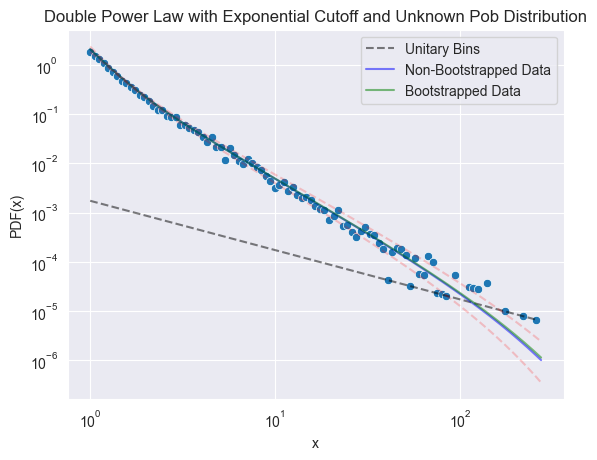

In [12]:
akaike = plg.akaike_information(x, plg.dslope_noprob_law_likelihood, (alpha1_pred, alpha2_pred, x_c_pred, beta_pred), x_min=x_min)
bayes = plg.bayesian_information(x, plg.dslope_noprob_law_likelihood, (alpha1_pred, alpha2_pred, x_c_pred, beta_pred), x_min=x_min)

print(f'Akaike Information Criteria: {round(akaike, 4)}\tBayesian Information Criteria: {round(bayes, 4)}')

print(f'Non-Bootstrapped Samples:\n\tSlope 1 Predicted: {alpha1_pred} +- {alpha1_std}\n\tSlope 2 Predicted: {alpha2_pred} +- {alpha2_std}\n\tDamping Factor Predicted: {x_c_pred} +- {x_c_std}\n\tProbability Predicted: {beta_pred} +- {beta_std}\n\tCrossing Point Predicted: {tau}')
print(f'\nBootstrapped Samples:\n\tSlope 1 Predicted: {alpha1_pred_bootstrap} +- {alpha1_std_bootstrap}\n\tSlope 2 Predicted: {alpha2_pred_bootstrap} +- {alpha2_std_bootstrap}\n\tDamping Factor Predicted: {x_c_pred_bootstrap} +- {x_c_std_bootstrap}\n\tProbability Predicted: {beta_pred_bootstrap} +- {beta_std_bootstrap}\n\tCrossing Point Predicted: {tau_b}')
        
plg.plot_data(x, n_bins, x_estimated, px_bootstrap, px, errors, title='Double Power Law with Exponential Cutoff and Unknown Pob Distribution')

## Real Data Analysis

### Data 1

In [13]:
data1 = pd.read_csv('data/c1/simBondPercAllp0.40hL256_lat_c1.dat', sep='\t', header=None)
x1 = data1[data1[0] >= 8][0].to_numpy() 
x1 = x1 / min(x1)
len(x1)

205493

Time ellapsed to Compute the Hessian: 0.002ms
Akaike Information Criteria: 598723.9883	Bayesian Information Criteria: 598734.2214

Non-Bootstrapped Samples:
	Slope Predicted: 2.3375514541512645 +- 0.0029506111662227132

Bootstrapped Samples:
	Slope Predicted: 2.3376471398143237 +- 0.00284645738602392


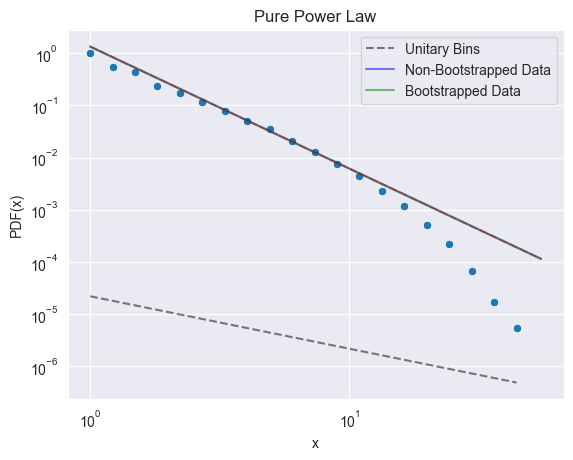

2.3375514541512645

In [17]:
plg.generate_power_law_sample(x=x1, alpha=2, x_min=1, show_data=True, n_bins=20, bootstrap=bootstrap)

Time ellapsed to Compute the Hessian: 2340.493ms
Akaike Information Criteria: 594388.3431	Bayesian Information Criteria: 594408.8094

Non-Bootstrapped Samples:
	Slope Predicted: 2.024222419784344 +- 0.00019488598537031256
	Damping Factor Predicted: 16.92121741281906 +- 0.016267127285602864

Bootstrapped Samples:
	Slope Predicted: 2.023816848294059 +- 0.0064491537934424446
	Damping Factor Predicted: 16.919650518447494 +- 0.3088096286310214


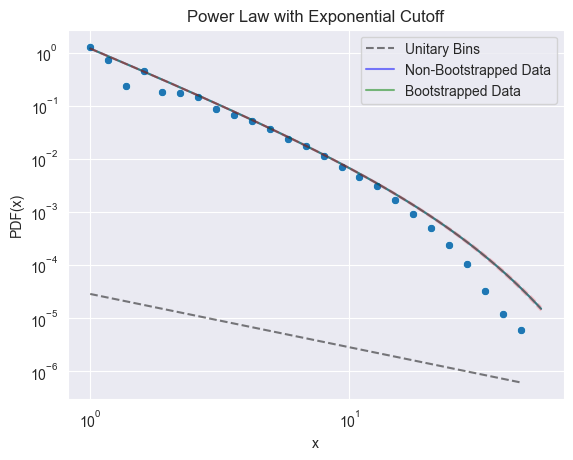

(2.024222419784344, 16.92121741281906)

In [19]:
plg.generate_cutoff_law_sample(x=x1, alpha=2.2, x_c=16, x_min=1, show_data=True, n_bins=25, bootstrap=bootstrap)

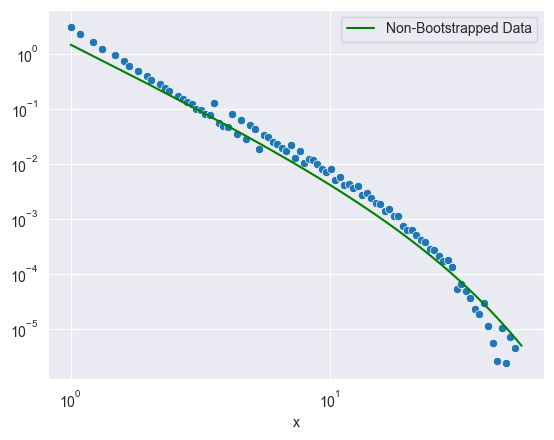

In [25]:
plt.yscale('log')
plt.xscale('log')
hist, bin_edges = np.histogram(np.log10(x1), bins=n_bins)
bin_width = [np.power(10, bin_edges[i + 1]) - np.power(10, bin_edges[i]) for i in range(len(bin_edges) - 1)]
t_hist = hist.sum()
hist = hist/bin_width / t_hist
x_hist = [np.log10(np.min(x1)) + np.log10(np.max(x1) - np.min(x1))*(i) / n_bins for i in range(len(hist))]
y_base = np.ones(len(x_hist))/bin_width / t_hist
x_estimated = np.linspace(np.floor(min(x1)), np.ceil(max(x1)), int(np.ceil(max(x1)) - np.floor(min(x1))))
px = plg.damped_power_pdf(x=x_estimated, alpha=2.3, x_c=16, x_min=1)
sns.scatterplot(x=np.power(10, x_hist), y=hist)
sns.lineplot(x=x_estimated, y=px, color='green', label='Non-Bootstrapped Data')
plt.xlabel("x")

plt.legend()
plt.show()

Time ellapsed to Compute the Hessian: 2153.957ms
Akaike Information Criteria: 589701.8343	Bayesian Information Criteria: 589732.5336

Non-Bootstrapped Samples:
	Slope 1 Predicted: 3.662011480057237 +- 0.008327094329312132
	Slope 2 Predicted: 0.5 +- 0.002829053863672253
	Damping Factor Predicted: 4.279512851432129 +- 0.01105383364202223
	Crossing Point Predicted: 1.519051816200214

Bootstrapped Samples:
	Slope 1 Predicted: 3.600718280699877 +- 0.02344419754264063
	Slope 2 Predicted: 0.6296050366251996 +- 0.016878732116367826
	Damping Factor Predicted: 4.7266871149329015 +- 0.07208931952091704
	Crossing Point Predicted: 1.6832769546182798


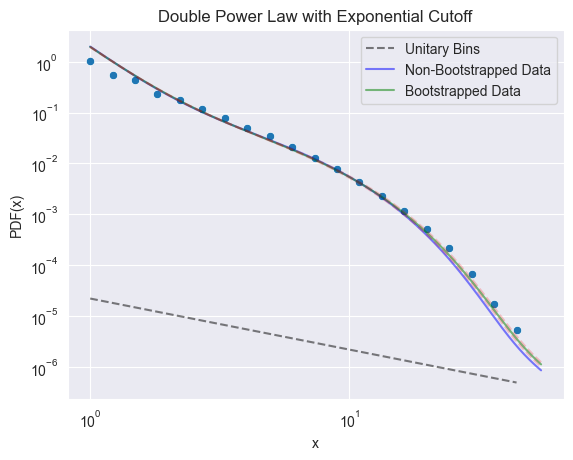

(3.662011480057237, 0.5, 4.279512851432129)

In [21]:
plg.generate_dslope_law_sample(x=x1, alpha1=3.5, alpha2=0.6, x_c=4, beta=0.7, x_min=x_min, show_data=True, n_bins=20, bootstrap=100)

In [4]:
plg.generate_dslope_noprob_law_sample(x=x1, alpha1=alpha1, alpha2=alpha2, x_c=x_c, beta=beta, x_min=x_min, show_data=True, n_bins=n_bins, bootstrap=2)

3.165648365132844 1.7170072544104709 95.80990397088104 0.49784686399752254
3.165648380034005 1.7170072544104709 95.80990397088104 0.49784686399752254
3.165648365132844 1.717007269311632 95.80990397088104 0.49784686399752254
3.165648365132844 1.7170072544104709 95.8099039857822 0.49784686399752254
3.165648365132844 1.7170072544104709 95.80990397088104 0.49784687889868373
2.000055997737169 1.9996613583571683 66.68490397088104 0.9999767848608762
2.8339833253456117 1.797435444619855 87.52249187553055 0.6407260941983928
2.833983340246773 1.797435444619855 87.52249187553055 0.6407260941983928
2.8339833253456117 1.7974354595210162 87.52249187553055 0.6407260941983928
2.8339833253456117 1.797435444619855 87.52249189043171 0.6407260941983928
2.8339833253456117 1.797435444619855 87.52249187553055 0.640726109099554
2.0018266759941694 1.9997904005913918 0.040879478061143004 0.42342416457768867
2.7507676604104674 1.8176709402170088 78.77433063578361 0.6189959012363223
2.7507676753116286 1.817670940

ZeroDivisionError: division by zero

### Data 2

In [23]:
data2 = pd.read_csv('data/c2/13_23_bzr_events_c2.dat', sep='\s', header=None)
x2 = data2[1].to_numpy()
len(x2)

5013

Time ellapsed to Compute the Hessian: 0.003ms
Akaike Information Criteria: 50530.631	Bayesian Information Criteria: 50537.15

Non-Bootstrapped Samples:
	Slope Predicted: 1.3383016081985804 +- 0.004778099727478932

Bootstrapped Samples:
	Slope Predicted: 1.3379357984337417 +- 0.0041243440635258055


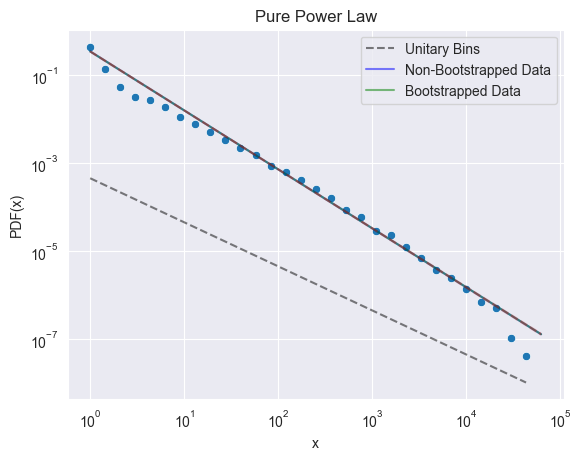

1.3383016081985804

In [26]:
plg.generate_power_law_sample(x=x2, alpha=alpha2, x_min=x_min, show_data=True, n_bins=30, bootstrap=bootstrap)

Time ellapsed to Compute the Hessian: 2238.008ms
Akaike Information Criteria: 59306.6892	Bayesian Information Criteria: 59319.7264

Non-Bootstrapped Samples:
	Slope Predicted: 2.0 +- 5.758646808353178e-05
	Damping Factor Predicted: 214671.91723726806 +- 1694.4614905299657

Bootstrapped Samples:
	Slope Predicted: 2.000008568639556 +- 3.0333807999613275e-05
	Damping Factor Predicted: 242594.01057037336 +- 124085.49050742916


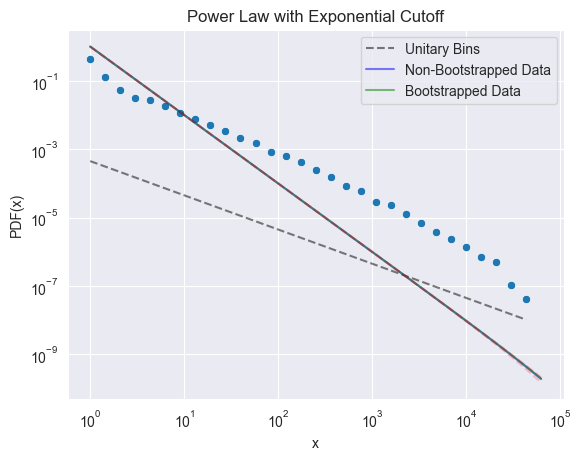

(2.0, 214671.91723726806)

In [28]:
plg.generate_cutoff_law_sample(x=x2, alpha=alpha2, x_c=x_c, x_min=x_min, show_data=True, n_bins=30, bootstrap=bootstrap)

Time ellapsed to Compute the Hessian: 11282.0ms
Non-Bootstrapped Samples:
	Slope 1 Predicted: 1.690393134241833 +- 0.01399493710314345
	Slope 2 Predicted: 1.0094132064997092 +- 0.010172252771789358
	Damping Factor Predicted: 10687.183980881298 +- 914.8367663372502
	Crossing Point Predicted: 16.95367853323936

Bootstrapped Samples:
	Slope 1 Predicted: 1.6457236816494936 +- 0.04568156267319947
	Slope 2 Predicted: 1.0124951601049101 +- 0.020780375983945738
	Damping Factor Predicted: 9317.737293012224 +- 782.8330435375321
	Crossing Point Predicted: 19.6675499216929


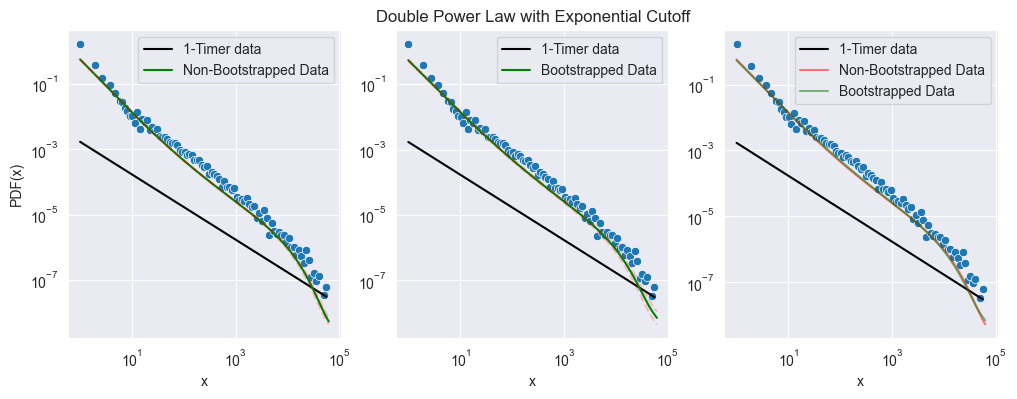

(1.690393134241833, 1.0094132064997092, 10687.183980881298)

In [4]:
plg.generate_dslope_law_sample(x=x2, alpha1=alpha1, alpha2=alpha2, x_c=x_c, beta=0.8, x_min=x_min, show_data=True, n_bins=30, bootstrap=2)

In [15]:
plg.generate_dslope_noprob_law_sample(x=x2, alpha1=alpha1, alpha2=alpha2, x_c=x_c, beta=0.8, x_min=x_min, show_data=True, n_bins=30, bootstrap=bootstrap)

TypeError: Cannot convert complex to float

### Data 3

In [22]:
data3 = pd.read_csv('data/c8/simELFBM-W-a1.50h0.00L256_it50.Seq', sep='\s+', header=None)
x3 = data3[7].to_numpy()
len(x3)

150463

Time ellapsed to Compute the Hessian: 0.0ms
Non-Bootstrapped Samples:
	Slope Predicted: 4.260865645466187 +- 0.008406554772812286

Bootstrapped Samples:
	Slope Predicted: 4.26184903099092 +- 0.017662417228224203


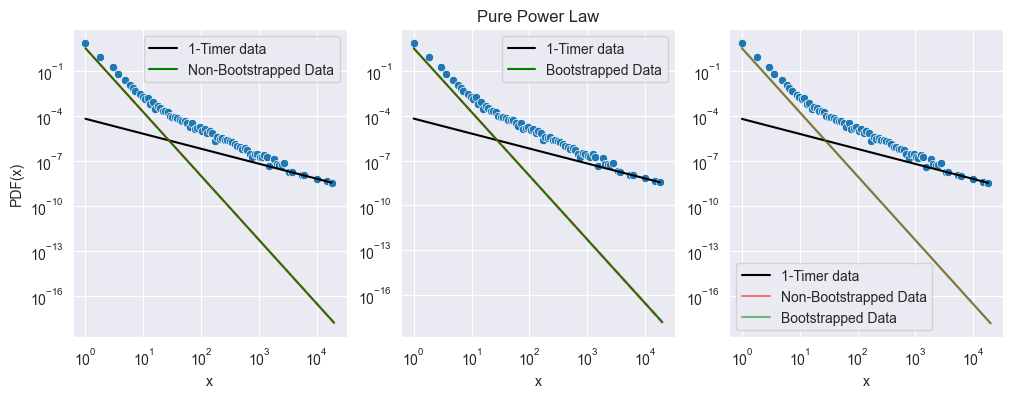

4.260865645466187

In [17]:
plg.generate_power_law_sample(x=x3, alpha=alpha2, x_min=x_min, show_data=True, n_bins=n_bins, bootstrap=bootstrap)

Non-Bootstrapped Samples:
	Slope Predicted: 4.260865649266474 +- 7.767003351266588e-13
	Damping Factor Predicted: 231503454438457.44 +- 105469965753.02344

Bootstrapped Samples:
	Slope Predicted: 4.261110911725657 +- 0.017068924190081
	Damping Factor Predicted: 1004140217768268.6 +- 872067120695841.8


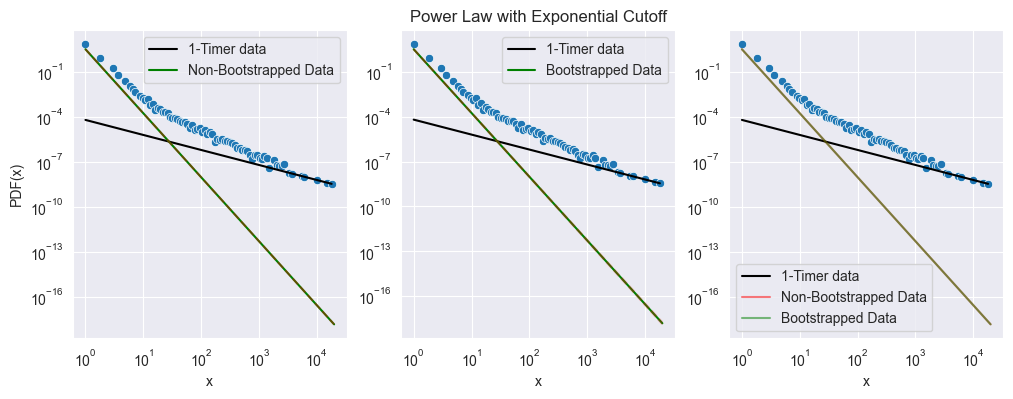

(4.260865649266474, 231503454438457.44)

In [ ]:
plg.generate_cutoff_law_sample(x=x3, alpha=alpha2, x_c=x_c, x_min=x_min, show_data=True, n_bins=n_bins, bootstrap=bootstrap)

In [ ]:
plg.generate_dslope_law_sample(x=x3, alpha1=alpha1, alpha2=alpha2, x_c=x_c, beta=beta, x_min=x_min, show_data=True, n_bins=n_bins, bootstrap=bootstrap)

TypeError: Cannot convert complex to float

In [ ]:
plg.generate_dslope_noprob_law_sample(x=x3, alpha1=alpha1, alpha2=alpha2, x_c=x_c, beta=0.8, x_min=x_min, show_data=True, n_bins=n_bins, bootstrap=bootstrap)

In [44]:
min(x3)

1

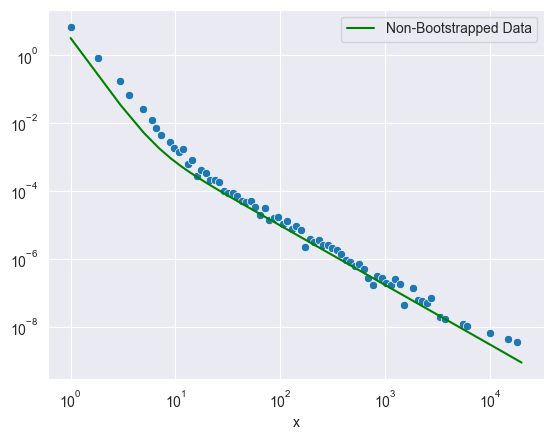

In [18]:
plt.yscale('log')
plt.xscale('log')
hist, bin_edges = np.histogram(np.log10(x3), bins=n_bins)
bin_width = [np.power(10, bin_edges[i + 1]) - np.power(10, bin_edges[i]) for i in range(len(bin_edges) - 1)]
t_hist = hist.sum()
hist = hist/bin_width / t_hist
x_hist = [np.log10(np.min(x3)) + np.log10(np.max(x3) - np.min(x3))*(i) / n_bins for i in range(len(hist))]
y_base = np.ones(len(x_hist))/bin_width / t_hist
x_estimated = np.linspace(min(x3), max(x3), n_samples)
px, tau = plg.dslope_power_pdf(x=x_estimated, alpha1=4.26, alpha2=1.75, x_c=1000000, beta=0.96, x_min=1)
sns.scatterplot(x=np.power(10, x_hist), y=hist)
sns.lineplot(x=x_estimated, y=px, color='green', label='Non-Bootstrapped Data')
plt.xlabel("x")
plt.title('BZR model simulation')
plt.legend()
plt.show()